# Time-Series Modelling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# splitting TS into components
from sklearn.metrics import mean_squared_error
# calculate RMSE
from math import sqrt

In [ ]:
from google.colab import files
uploaded=files.upload()
# CDAC_DataBook.xlsx
# to be used with google colab

# import os
# os.chdir(r'C:\Users\surya\Downloads\PG-DBDA-Mar23\Datasets')
# os.getcwd()
# to change current working directory to specified path
# to be used while running on local system

Saving CDAC_DataBook.xlsx to CDAC_DataBook.xlsx


In [ ]:
df = pd.read_excel('CDAC_DataBook.xlsx', sheet_name='birth')
df.head

<bound method NDFrame.head of      BirthRate
0       26.663
1       23.598
2       26.931
3       24.740
4       25.806
..         ...
163     30.000
164     29.261
165     29.012
166     26.992
167     27.897

[168 rows x 1 columns]>

In [ ]:
df.columns

Index(['BirthRate'], dtype='object')

<Axes: >

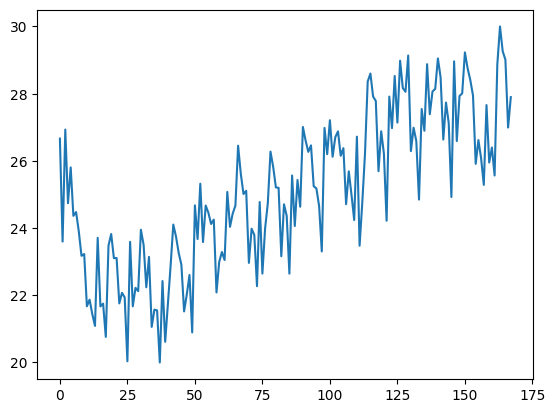

In [ ]:
df.BirthRate.plot()
# plotting the time series

In [ ]:
df_train = df.iloc[:144]
# splitting 12 years data to training data
df_test = df.iloc[144:]
# splitting 02 years data to test data

# created training & testing data manually without train_test_split(),
# because we do not want it to select row randomly
# as randomization in Time-Series Modelling will impact results

In [ ]:
df_train.shape

(144, 1)

In [ ]:
df_test.shape

(24, 1)

<Axes: >

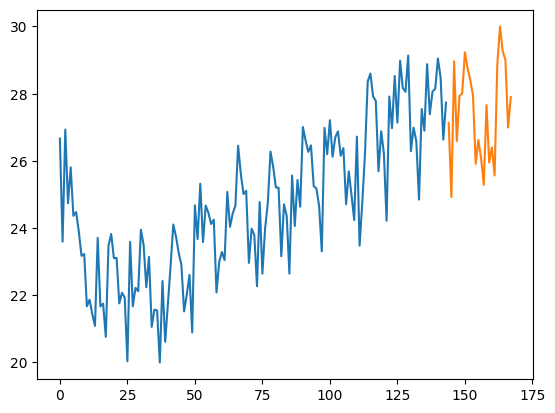

In [ ]:
df_train.BirthRate.plot()
df_test.BirthRate.plot()

In [ ]:
from pandas.core.arrays import period

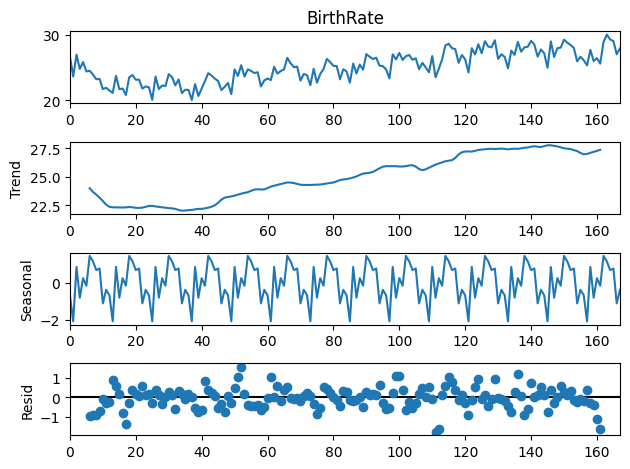

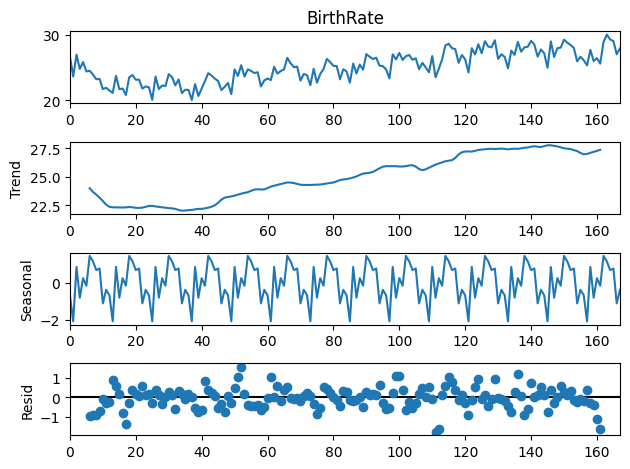

In [ ]:
res = statsmodels.tsa.seasonal.seasonal_decompose(df.BirthRate, period=12)
# decomposes the TimeSeries into its components
res.plot()
# to plot & see the decomposed components of TImeSeries

In [ ]:
type(res)

statsmodels.tsa.seasonal.DecomposeResult

## Naive method
- assume that the last value from training data will keep on going for the future, then compare the forecast with the test data to find error

In [ ]:
df_train.BirthRate.tail()

139    28.141
140    29.048
141    28.484
142    26.634
143    27.735
Name: BirthRate, dtype: float64

In [ ]:
# Naive method
dd = np.array(df_train.BirthRate)

In [ ]:
y_hat = df_test.copy()
# copying test data to y_hat
# y_hat : testing data
y_hat.head()

,BirthRate
144,27.132
145,24.924
146,28.963
147,26.589
148,27.931


In [ ]:
y_hat['naive'] = dd[len(dd)-1]
# adds another column 'naive' with last value from ndarray 'dd'
# to get the last value
y_hat.tail()

,BirthRate,naive
163,30.000,27.735
164,29.261,27.735
165,29.012,27.735
166,26.992,27.735
167,27.897,27.735


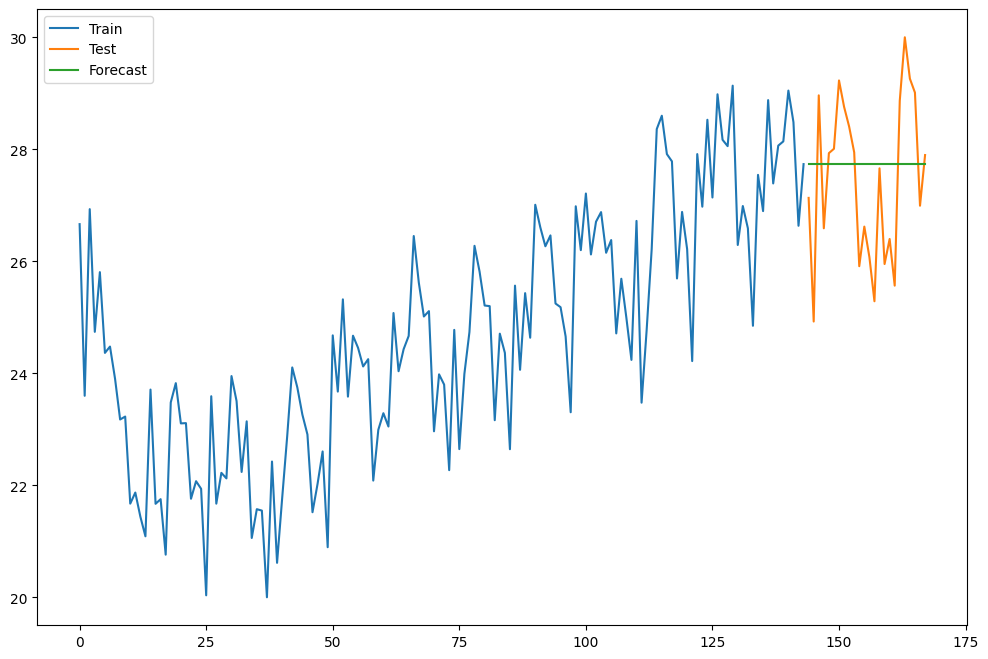

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat.index, y_hat.naive, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat.naive))
# calculates root mean squared error
# between test data & naive data from train data
rms

1.4277309211939526

## Simple Average Method
- assume that average of all the values will continue for the each month next years

In [ ]:
y_hat_avg = df_test.copy()
y_hat_avg['MeanForecast'] = df_train['BirthRate'].mean()
y_hat_avg.head()

,BirthRate,MeanForecast
144,27.132,24.656833
145,24.924,24.656833
146,28.963,24.656833
147,26.589,24.656833
148,27.931,24.656833


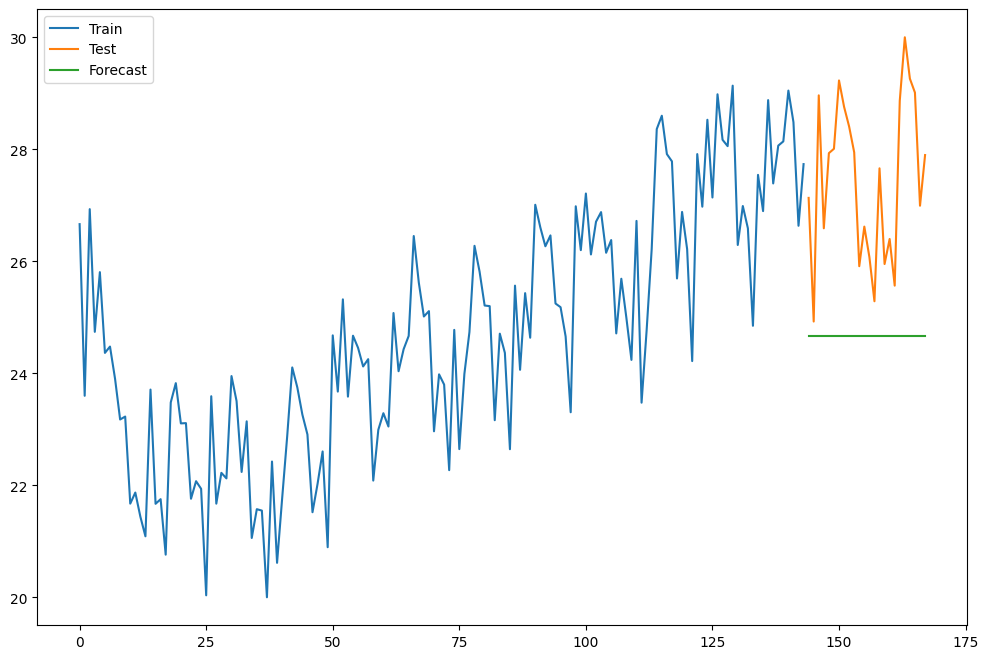

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.MeanForecast, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.MeanForecast))
# calculates root mean squared error
# between test data & MeanForecast data from train data
rms

# note that the RMS value in Simple Average method is lower due to
# dip in early values of training data

3.147657647627305

## Moving Average
- used in stock market
- a series of averages, calculated from historic data
- assume that forecast .....
- take only the last values as per time period set, like last 3 months, 6 months, 12months etc.
- assume that the moving average of last time period in last cycle/year is the current forecast
- use the time period window based on which time period window gives you lowest RMSE

In [ ]:
# y_hat_avg = df_test.copy()
y_hat_avg['MovAvgForecast'] = df_train['BirthRate'].rolling(12).mean().iloc[-1]
y_hat_avg.head()

,BirthRate,MeanForecast,MovAvgForecast
144,27.132,24.656833,27.520917
145,24.924,24.656833,27.520917
146,28.963,24.656833,27.520917
147,26.589,24.656833,27.520917
148,27.931,24.656833,27.520917


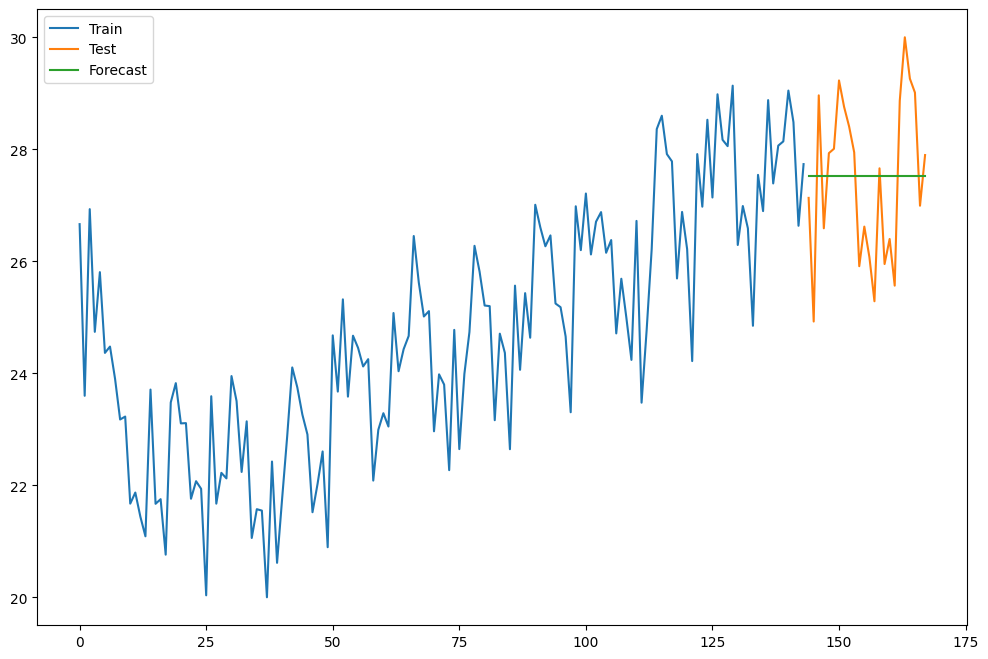

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.MovAvgForecast, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.MovAvgForecast))
# calculates root mean squared error
# between test data & MeanForecast data from train data
rms

# you need to change the rolling(12) value to 6, 3, etc. and
# see which window gives you the lowest RMSE, and proceed with that one only

1.4044810849760687

## Weighted Moving Average
- works on weigted average
- suppose we have data of a year, then we have to assign weight to each month
- newest month will have highest weight
- oldest month will have lowest weight
- then calculate the weighted average for the last cycle/year, which will be the current forecast

In [ ]:
x = df_train['BirthRate'].iloc[-12:]

In [ ]:
wt_sum = 0
denom = 0
for ctr in range(len(x)):
    wt_sum = wt_sum + x.iloc[ctr]*(ctr+1)
    # sums up the product of weight & value
    denom = denom + ctr+1
    # sums up all the weights
wt_avg = wt_sum / denom

In [ ]:
# y_hat_avg = df_test.copy()
y_hat_avg['WtMovAvgForecast'] = wt_avg
y_hat_avg.head()

,BirthRate,MeanForecast,MovAvgForecast,WtMovAvgForecast
144,27.132,24.656833,27.520917,27.806115
145,24.924,24.656833,27.520917,27.806115
146,28.963,24.656833,27.520917,27.806115
147,26.589,24.656833,27.520917,27.806115
148,27.931,24.656833,27.520917,27.806115


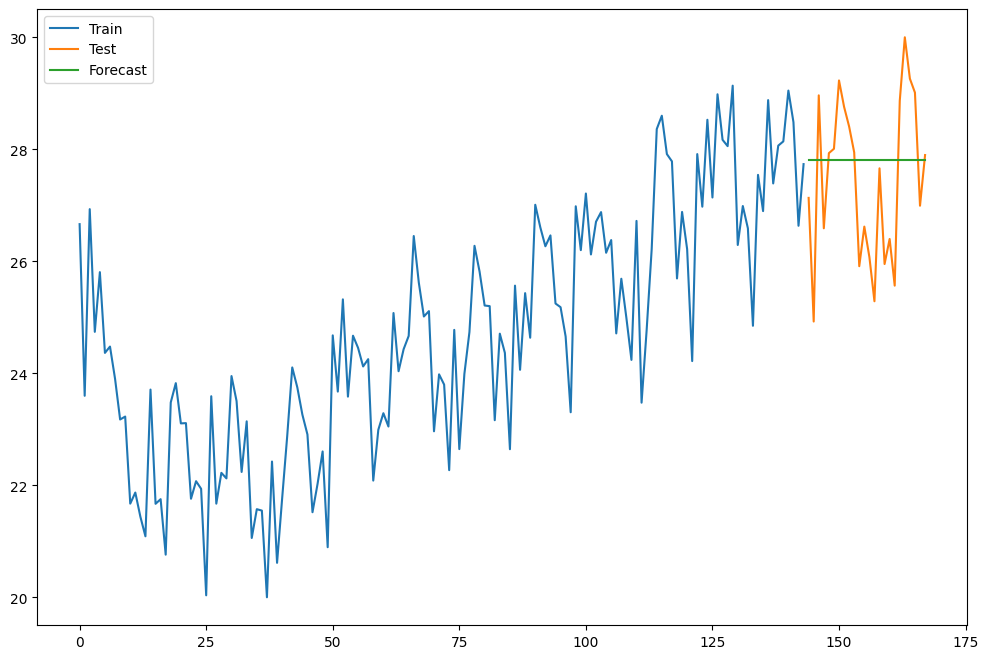

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.WtMovAvgForecast, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.MovAvgForecast))
# calculates root mean squared error
# between test data & MeanForecast data from train data
rms


1.4044810849760687

## Exponential Smoothing
- to forecast univatiate time series data
- uses exponential window function

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Simple Exponential Smoothing

In [ ]:
# Simple Exponential Smoothing
mod1 = SimpleExpSmoothing(np.asarray(df_train.BirthRate)).fit(smoothing_level=0.8)

In [ ]:
y_hat_avg['SES'] = mod1.forecast(len(df_test))
y_hat_avg.head()

,BirthRate,MeanForecast,MovAvgForecast,WtMovAvgForecast,SES
144,27.132,24.656833,27.520917,27.806115,27.591807
145,24.924,24.656833,27.520917,27.806115,27.591807
146,28.963,24.656833,27.520917,27.806115,27.591807
147,26.589,24.656833,27.520917,27.806115,27.591807
148,27.931,24.656833,27.520917,27.806115,27.591807


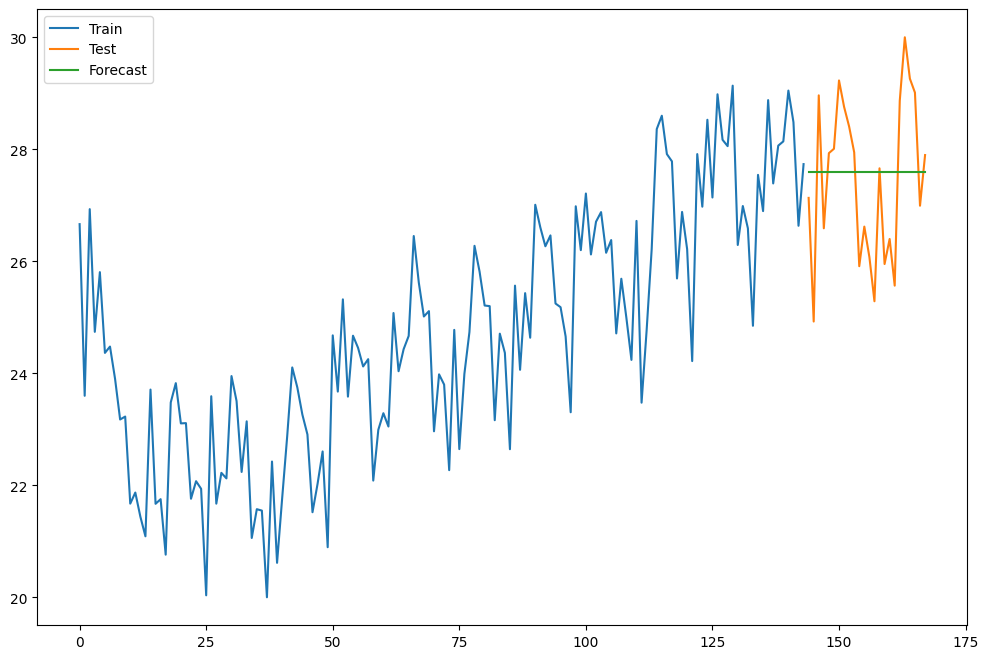

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.SES, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.SES))
# calculates root mean squared error
# between test data & SES data from train data
rms


1.4086237555629835

###Holt's Linear Trend Method

In [ ]:
# Holt's Linear Trend Method
mod1 = Holt(np.asarray(df_train.BirthRate)).fit(smoothing_level=0.6)

In [ ]:
y_hat_avg['HoltLinear'] = mod1.forecast(len(df_test))
y_hat_avg.head()

,BirthRate,MeanForecast,MovAvgForecast,WtMovAvgForecast,SES,HoltLinear
144,27.132,24.656833,27.520917,27.806115,27.591807,27.621742
145,24.924,24.656833,27.520917,27.806115,27.591807,27.634163
146,28.963,24.656833,27.520917,27.806115,27.591807,27.646583
147,26.589,24.656833,27.520917,27.806115,27.591807,27.659004
148,27.931,24.656833,27.520917,27.806115,27.591807,27.671424


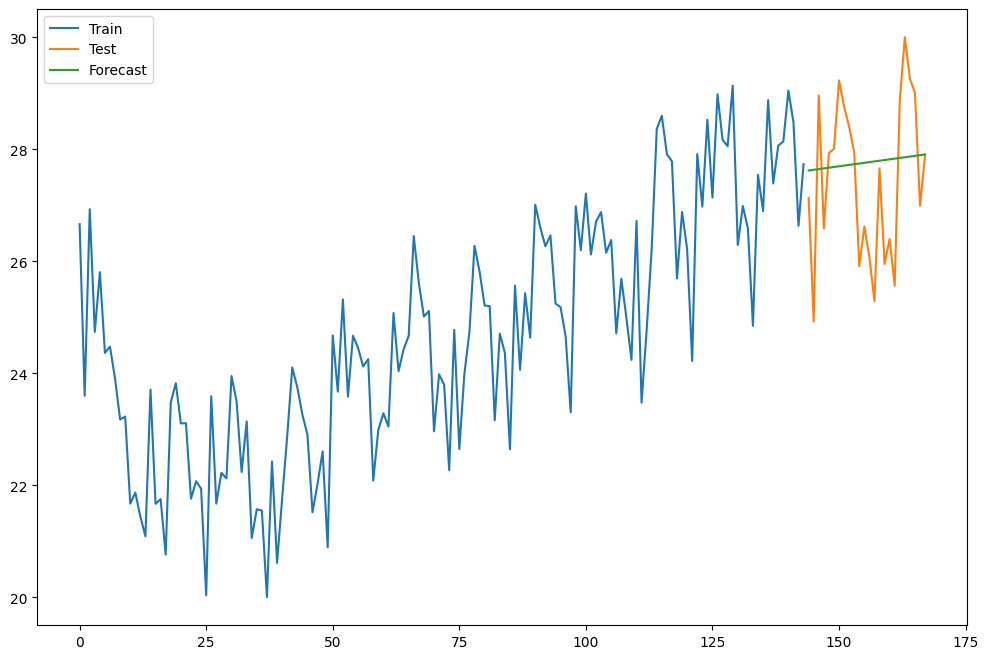

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.HoltLinear, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.HoltLinear))
# calculates root mean squared error
# between test data & HoltLinear data from train data
rms

1.4238880670306986

### Holt-Winter's method

In [ ]:
mod3 = ExponentialSmoothing(np.asarray(df_train.BirthRate) , seasonal_periods=)

In [ ]:
y_hat_avg['HoltWinter'] = mod1.forecast(len(df_test))
y_hat_avg.head()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_train.index, df_train.BirthRate, label='Train')
plt.plot(df_test.index, df_test.BirthRate, label='Test')
plt.plot(y_hat_avg.index, y_hat_avg.HoltWinter, label='Forecast')
plt.legend()

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, y_hat_avg.HoltWinter))
# calculates root mean squared error
# between test data & HoltWinter data from train data
rms

## ARIMA Model
- ARIMA: Auto-Regressive Integrated Moving Average
- combination of weighted Moving average & ...
- input arguments are dataframe and p, d, q
- d: central value, level of differencing which converts a non-stationary Time-Series into a stationary Time-Series
- p:
- q:
- Stationary time series, mean doesn't change, but
- can be used only when data set is converted into stationary Time-Series


- Differencing
        4, 8, 5, 9, 6, 8, 7  - actual values
         4, 3, 4, 3, 2, 1    - first level of differecning
           1, 1, 1, 1        - second level of differecning

-

### AD Fuller test
- for finding the value of 'd' - level of differencing
- to check the stationarity of a time series
- H 0 : the time series is not stationary
- H a : the time series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(df_train)
# returns (TestStatistic, P-Value, lags, n_obs, critical values, res_store)
# here P-Value 0.972 > 0.05, so H 0 is not rejected

(0.2017160479163269,
 0.9723576777571017,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 322.55907506392055)

-

In [ ]:
# after first level of differencing
# d = 1
adfuller(df_train.diff().dropna())
# returns (TestStatistic, P-Value, lags, n_obs, critical values, res_store)
# here P-Value 0.0005 < 0.05, so H 0 is rejected
# so time series is now stationary

(-4.253904918858687,
 0.0005333378978881231,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 314.64706729275866)

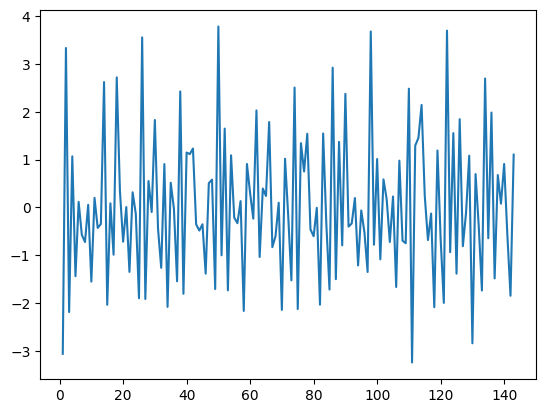

In [ ]:
plt.plot(df_train.diff())

In [ ]:
# after Second level of differencing
# d = 2 , for double checking if Time-Series is stationary
adfuller(df_train.diff().diff().dropna())
# returns (TestStatistic, P-Value, lags, n_obs, critical values, res_store)
# here P-Value is almost zero < 0.05, so H 0 is rejected
# so time series is now stationary

(-7.414679804135267,
 6.985733866859221e-11,
 14,
 127,
 {'1%': -3.482920063655088,
  '5%': -2.884580323367261,
  '10%': -2.5790575441750883},
 329.7642316985588)

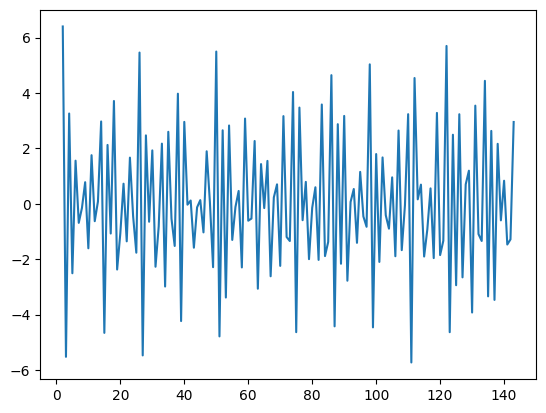

In [ ]:
plt.plot(df_train.diff().diff())

### Lag
- Y t : actual values [4, 8, 5, 9, 6, 8, 7] - 0th lag
- Y t+1 : 1st lag
- Y t+2 : 2nd lag

- ```Y t```  and ```Y t+1``` have direct relation, ```Y t+1``` and ```Y t+2``` have direct relation, so ```Y t``` and ```Y t+2``` have indirect relation
-

### PACF plot
- Partial Auto-Correlation Factor Plot
- gives value of 'p'
- shows only direct correlation

### ACF plot
- Auto-Correlation Factor Plot
- gives value of 'q'
- when lag becomes insignnificant, that lag is value of 'q'
- shows direct & indirect correlation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

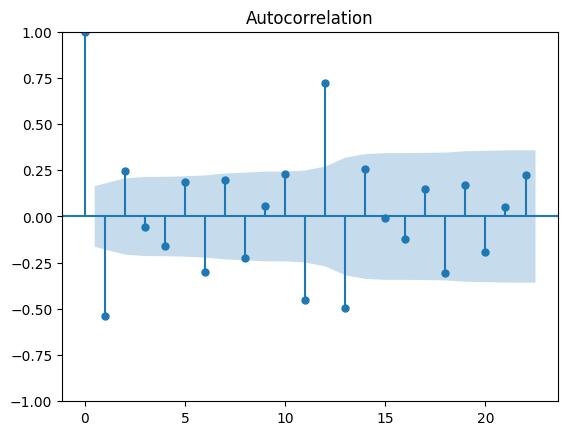

<Figure size 1200x800 with 0 Axes>

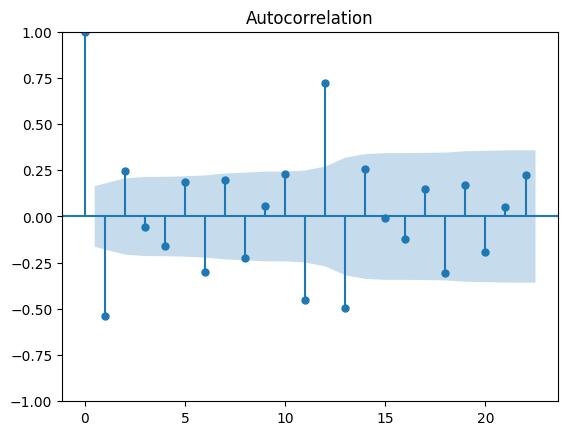

In [ ]:
plt.figure(figsize=(12, 8))
plot_acf(df_train.diff().dropna())
# at zeroth lag, acf value is 1
# you can ignore the acf values
# which are not significant, which lie outside blue area

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


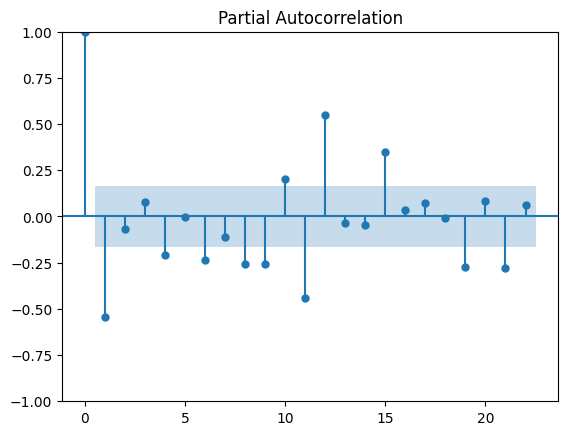

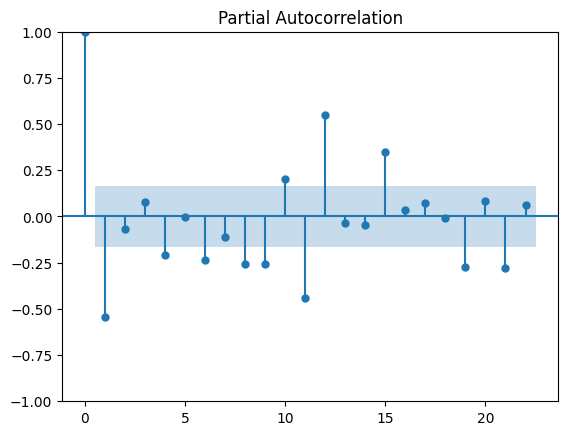

In [ ]:
plot_pacf(df_train.diff().dropna())
# at zeroth lag, acf value is 1
# you can ignore the acf values

- d = 1 [level of differencing]
- p = 1 [from PACF graph]
- q = 2 [from ACF graph]

### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
mod4 = ARIMA(df_train, order=(1, 1, 2)).fit()
#ARIMA(df_train, order=(d, p, q)).fit()

In [ ]:
pred = mod4.predict(len(df_test))

In [ ]:
rms = sqrt(mean_squared_error(df_test.BirthRate, pred))
# calculates root mean squared error
# between test data & pred data  generated using train data into ARIMA
rms


ValueError: ignored